# Churn rate

В этом задании вам предлагается проанализировать данные одной из американских телекоммуникационных компаний  о пользователях, которые потенциально могут уйти.

  Измерены следующие признаки:

   - state — штат США
   - account_length — длительность использования аккаунта
   - area_code — деление пользователей на псевдорегионы, использующееся в телекоме
   - intl_plan — подключена ли у пользователя услуга международного общения
   - vmail_plan — подключена ли у пользователя услуга голосовых сообщений
   - vmail_message — количество голосых сообщений, который пользователь отправил / принял
   - day_calls — сколько пользователь совершил дневных звонков
   - day_mins — сколько пользователь проговорил минут в течение дня
   - day_charge — сколько пользователь заплатил за свою дневную активность
   - eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
   - night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
   - intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
   - custserv_calls — сколько раз пользователь позвонил в службу поддержки
   - treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)

   - mes_estim — оценка интенсивности пользования интернет мессенджерами
   - churn — результат оттока: перестал ли абонент пользоваться услугами оператора

In [123]:
import warnings
warnings.filterwarnings('ignore')

In [124]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.stats.multitest as smm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.sandbox.stats.multicomp import multipletests 
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import *
import matplotlib.pyplot as plt

In [125]:
print(np.__version__)
print(pd.__version__)
print(sc.__version__)
print(statsmodels.__version__)

1.19.2
1.2.1
1.5.2
0.12.1


In [126]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
data = pd.read_csv('churn_analysis.csv', sep=',')
pd.set_option('display.max_columns', None)
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


In [68]:
data.churn.value_counts()

False.    2850
True.      483
Name: churn, dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state           3333 non-null   object 
 1   account_length  3333 non-null   int64  
 2   area_code       3333 non-null   int64  
 3   intl_plan       3333 non-null   object 
 4   vmail_plan      3333 non-null   object 
 5   vmail_message   3333 non-null   int64  
 6   day_mins        3333 non-null   float64
 7   day_calls       3333 non-null   int64  
 8   day_charge      3333 non-null   float64
 9   eve_mins        3333 non-null   float64
 10  eve_calls       3333 non-null   int64  
 11  eve_charge      3333 non-null   float64
 12  night_mins      3333 non-null   float64
 13  night_calls     3333 non-null   int64  
 14  night_charge    3333 non-null   float64
 15  intl_mins       3333 non-null   float64
 16  intl_calls      3333 non-null   int64  
 17  intl_charge     3333 non-null   f

# Task 1

Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора. 

Для этого мы воспользуемся критерием хи-квадрат.  Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn.  Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции 

Заметьте, что, например, (AZ, HI)  и  (HI, AZ) — это одна и та же пара. Обязательно выставьте correction=False (о том, что это значит, вы узнаете из следующих вопросов).

Сколько  достигаемых уровней значимости оказались меньше, чем α=0.05?

In [73]:
data_states = pd.pivot_table(data=data[data['treatment'] == 1], columns ='churn', index='state', values='treatment', fill_value=0, aggfunc=len)

In [74]:
data_states.head()

churn,False.,True.
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5


In [75]:
data_states.index

Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI', 'WV', 'WY'],
      dtype='object', name='state')

In [76]:
%%time 

chi2_data = []

for i, state_1 in enumerate(data_states.index):
    for j, state_2 in enumerate(data_states.index):
        if i >= j:
            continue
        
        chi2, p, _, _ = sc.stats.chi2_contingency(data_states.loc[[state_1,state_2],:], correction=False)
        chi2_data.append([state_1, state_2, chi2, p])

CPU times: user 958 ms, sys: 19.5 ms, total: 978 ms
Wall time: 951 ms


In [77]:
chi2_states = pd.DataFrame.from_records(chi2_data)
chi2_states.columns = ['State_A', 'State_B', 'Chi2', 'p']
chi2_states.head()

,State_A,State_B,Chi2,p
0,AK,AL,1.546717,0.213621
1,AK,AR,4.410000,0.035729
2,AK,AZ,0.419079,0.517397
3,AK,CA,4.844349,0.027737
4,AK,CO,2.688636,0.101066


In [78]:
number = chi2_states[chi2_states.p <= 0.05].p.shape[0]

In [79]:
print('Num of significance lvls below 0.05 is: ',number)

Num of significance lvls below 0.05 is:  34


Ответ: (1 балов)
 - 34


# Task 2

- Анализ нужно было начинать с применения xи-квадрат к  таблице сопряженности, в которой  присутствовали сразу все возможные штаты. Достигаемой уровень значимости такой проверки = 0.7, что дает нам гарантию, что нет ни одной пары штатов, в которых отличие в соотношениях ушедших и оставшихся клиентов  статистически значимо. 

- Поправку на множественную проверку  здесь применять нельзя — она   используется только для группы критериев, проверяющих равенство средних (типа t-критерия). Критерий xи-квадрат не принадлежит этому семейству, поэтому поправка не нужна.

- Применение критерия xи-квадрат для этих данных не обосновано, потому что не выполняются условия, при которых этот критерий дает правильные результаты. 

- Интерпретация числа достигаемых уровней значимости,  меньших α=0.05, некорректна,  поскольку не сделана поправка на множественную проверку гипотез.

- Хи-квадрат используется для того, чтобы сравнить выборку с некоторым воздействием  (treatment) и выборку без этого воздействия (control). Мы же в первом задании сравнивали штаты, используя данные только control группы. Для данных только из control группы  использование xи-квадрат неправомерно. 

Ответ: (0.6 балов)
 - Интерпретация числа достигаем,
 - Хи-квадрат


Ответ: (0.8 балов)
 - Интерпретация числа достигаем,


# Task 3

- Количество достигаемых уровней значимости, меньших, чем 0.05, в точности равно нулю. То есть поправка увеличила достигаемые уровни значимости настолько, что больше ни одно из значений  достигаемого уровня значимости не попадает в диапазон от 0 до 0.05.

- Поправка Йетса на непрерывность всегда увеличивает значение  достигаемого уровня значимости, поэтому все получившиеся значения  достигаемого уровня значимости строго больше  или равны таковым значениям при отсутствии этой поправки.

- Количество  достигаемых уровней значимости, меньших, чем 0.05, почти не изменилось, нельзя сказать, что введенная  поправка сильно поменяла достигаемые уровни значимости.

- Достигаемые уровни значимости на наших данных,  полученные с помощью критерия xи-квадрат с поправкой Йетса,  в среднем получаются больше, чем соответствующие значения  без поправки.

In [80]:
%%time 
chi2_data_corr = []

for i, state_1 in enumerate(data_states.index):
    for j, state_2 in enumerate(data_states.index):
        if i >= j:
            continue
        
        chi2, p, _, _ = sc.stats.chi2_contingency(data_states.loc[[state_1,state_2],:], correction=True)
        chi2_data_corr.append([state_1, state_2, chi2, p])

CPU times: user 902 ms, sys: 9.23 ms, total: 911 ms
Wall time: 903 ms


In [82]:
chi2_states_corr = pd.DataFrame.from_records(chi2_data_corr)
chi2_states_corr.columns = ['State_A', 'State_B', 'Chi2_corr', 'p_corr']
chi2_states_corr['p_standart'] = chi2_states['p']
chi2_states_corr.head()

,State_A,State_B,Chi2_corr,p_corr,p_standart
0,AK,AL,0.639205,0.423999,0.213621
1,AK,AR,2.722500,0.098943,0.035729
2,AK,AZ,0.002138,0.963119,0.517397
3,AK,CA,3.054957,0.080491,0.027737
4,AK,CO,1.435795,0.230821,0.101066


In [85]:
number = chi2_states_corr[chi2_states_corr['p_corr'] <= 0.05].p_corr.shape[0]

In [98]:
print('Num of significance lvls below 0.05 is: ',number)

Num of significance lvls below 0.05 is:  0


In [93]:
chi2_states_corr['p_standart'].mean() <= chi2_states_corr['p_corr'].mean()

True

Ответ: (0 балов)
 - Количество достигаемых уровней значимости, меньших, чем 0.05, в точности равно нулю. То есть поправка увеличила достигаемые уровни значимости настолько, что больше ни одно из значений  достигаемого уровня значимости не попадает в диапазон от 0 до 0.05.
 
 - Достигаемые уровни значимости на наших данных,  полученные с помощью критерия xи-квадрат с поправкой Йетса,  в среднем получаются больше, чем соответствующие значения  без поправки.


Ответ: (1 балов)
 - Количество достигаемых уровней значимости, меньших, чем 0.05, в точности равно нулю. То есть поправка увеличила достигаемые уровни значимости настолько, что больше ни одно из значений  достигаемого уровня значимости не попадает в диапазон от 0 до 0.05.
 
 - Достигаемые уровни значимости на наших данных,  полученные с помощью критерия xи-квадрат с поправкой Йетса,  в среднем получаются больше, чем соответствующие значения  без поправки.


# Task 4

Что если у нас мало данных,  мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку,  предположения  критерия xи-квадрат не выполняются, а проверить гипотезу о том, что данные принадлежат одному распределению, нужно ?

В таком случае прибегают к так называемому точному критерию Фишера. Этот  критерий не использует приближений  и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.

В числителе этой дроби стоит суммарное количество способов выбрать aaa и ccc из a+ba +b a+b и c+dc + dc+d соответственно. А в знаменателе — количество способов выбрать число объектов, равное сумме элементов первого столбца a+ca + ca+c из общего количества рассматриваемых объектов nnn.

Чтобы посчитать достигаемый уровень значимости критерия Фишера, нужно перебрать все возможные значения a,b,c,da, b, c, d a,b,c,d, в клетках этой таблицы так, чтобы построковые и постолбцовые суммы не изменились. Для каждого такого набора a,b,c,da, b, c, d a,b,c,d нужно вычислить значение pi p_i pi​ по формуле выше и просуммировать все такие значения pi p_i pi​, которые меньше или равны p pp, которое мы вычислили по наблюдаемым значениям a,b,c,da, b, c, d a,b,c,d.

Понятно, что такой критерий вычислительно неудобен в силу большого количества факториалов в формуле выше. То есть даже при небольших выборках для вычисления значения этого критерия приходится оперировать очень большими числами. Поэтому данным критерием пользуются обычно только для таблиц 2x2, но сам критерий никак не ограничен количеством строк и столбцов, и его можно построить для любой таблицы n×mn\times mn×m.

Посчитайте для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами, описанными выше.

Точный критерий Фишера удобно вычислять с помощью функции 

In [94]:
%%time 
fisher_data = []

for i, state_1 in enumerate(data_states.index):
    for j, state_2 in enumerate(data_states.index):
        if i >= j:
            continue
        
        fisher, p = sc.stats.fisher_exact(data_states.loc[[state_1,state_2],:])
        fisher_data.append([state_1, state_2, fisher, p])

CPU times: user 2.71 s, sys: 1.06 ms, total: 2.71 s
Wall time: 2.7 s


In [96]:
fisher_states = pd.DataFrame.from_records(fisher_data)
fisher_states.columns = ['State_A', 'State_B', 'Fisher', 'p_fisher']
fisher_states['p_standart'] = chi2_states['p']
fisher_states['p_Yetse'] = chi2_states_corr['p_corr']
fisher_states.head()

,State_A,State_B,Fisher,p_fisher,p_standart,p_Yetse
0,AK,AL,3.800000,0.381063,0.213621,0.423999
1,AK,AR,8.636364,0.068862,0.035729,0.098943
2,AK,AZ,2.235294,0.604990,0.517397,0.963119
3,AK,CA,9.500000,0.063965,0.027737,0.080491
4,AK,CO,5.588235,0.187034,0.101066,0.230821


In [13]:
number = fisher_states[fisher_states.p <= 0.05].p.shape[0]

In [14]:
print('Num of significance lvls below 0.05 is: ',number)

Num of significance lvls below 0.05 is:  10


In [98]:
fisher_states['p_standart'].mean(), fisher_states['p_Yetse'].mean(), fisher_states['p_fisher'].mean()

(0.5018273798739158, 0.6640566382051047, 0.6483383060020681)

- Точный  критерий Фишера на наших данных дает значения  достигаемого уровня значимости в среднем большие, чем xи-квадрат с поправкой Йетса

- Точный критерий Фишера всегда лучше, чем критерий xи-квадрат, потому что не использует аппроксимацию дискретного распределения непрерывным. Однако при увеличении размера выборки его преимущества по сравнению с критерем xи-квадрат уменьшаются, в пределе достигая нуля.

- Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем значительно большие, чем xи-квадрат без поправки

- Точный  критерий Фишера точно также, как и критерий xи-квадрат,  нельзя использовать, если наблюдений < 40  и если ожидаемое значение меньше 5 больше чем в 20% ячейках. 

- Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат с поправкой Йетса

- Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат без поправки

Ответ: (0.833 балов)



- Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем значительно большие, чем xи-квадрат без поправки

- Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат с поправкой Йетса

Ответ: (1. балов)



- Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем значительно большие, чем xи-квадрат без поправки

- Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат с поправкой Йетса

- Точный критерий Фишера всегда лучше, чем критерий xи-квадрат, потому что не использует аппроксимацию дискретного распределения непрерывным. Однако при увеличении размера выборки его преимущества по сравнению с критерем xи-квадрат уменьшаются, в пределе достигая нуля.

# Task 5

Давайте попробуем применить полученные знания о разных видах корреляции и ее применимости на практике. 

Рассмотрим пару признаков day_calls и  mes_estim. Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость. 

Отметьте все верные утверждения. 

- Все варианты неверны, потому что значимость корреляции Пирсона можно оценивать только для нормального распределения, как и упоминалось в лекциях. 

- Корреляция Пирсона имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 не значимо. 

- Корреляция Пирсона имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 не значимо. 

- Корреляция Пирсона имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо. 

- Корреляция Пирсона имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.

In [28]:
print('Pearson correlation: {}'.format(sc.stats.pearsonr(data.day_calls, data.mes_estim)[0]))
print('Pearson p-value: {}'.format(sc.stats.pearsonr(data.day_calls, data.mes_estim)[1]))

Pearson correlation: -0.05179435058757264
Pearson p-value: 0.0027798836869738384


Ответ: (1 балов)

- Корреляция Пирсона имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо. 

# Task 6

Еще раз рассмотрим пару признаков day_calls и  mes_estim. Посчитайте корреляцию Спирмена между этими признаками на всех данных, ее значимость.

Отметьте все верные утверждения. 

- Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.

- Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 не значимо.

- Корреляция Спирмена имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 не значимо.

- Корреляция Спирмена тут неприменима, поскольку речь идет о непрерывных величинах, а корреляция Спирмена применяется к выборочным рангам  двух выборок. 

- Корреляция Спирмена имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.

In [29]:
print('Spearman correlation: {}'.format(sc.stats.spearmanr(data.day_calls, data.mes_estim)[0]))
print('Spearman p-value: {}'.format(sc.stats.spearmanr(data.day_calls, data.mes_estim)[1]))

Spearman correlation: 0.043349880533927444
Spearman p-value: 0.012317367189170541


Ответ: (0 балов)

- Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.

Ответ: (0 балов)

- Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 NOT значимо.

# Task 7

Как можно интерпретировать полученные значения коэффициентов корреляции и достигаемые уровни значимости при проверки гипотез о равенстве нулю этих коэффициентов?

- Не стоит ориентироваться на значение корреляции Спирмена, потому что корреляцию Спирмена можно считать только тогда, когда оба признака дискретные и между значениями можно установить строгий порядок. 

- Предположение нормальности данных двух признаков не выполнено, что хорошо видно на ку-ку графике, поэтому корреляция Пирсона может быть полностью неадекватна.

- Посчитанные корреляции и их значимости говорят лишь о том, что необходимо взглянуть на данные глазами и попытаться понять, что приводит к таким (противоречивым?) результатам.

- Подсчет корреляций не имеет особого смысла, поскольку корреляция ничего не говорит о том, какая на самом деле зависимость имеется между признаками.

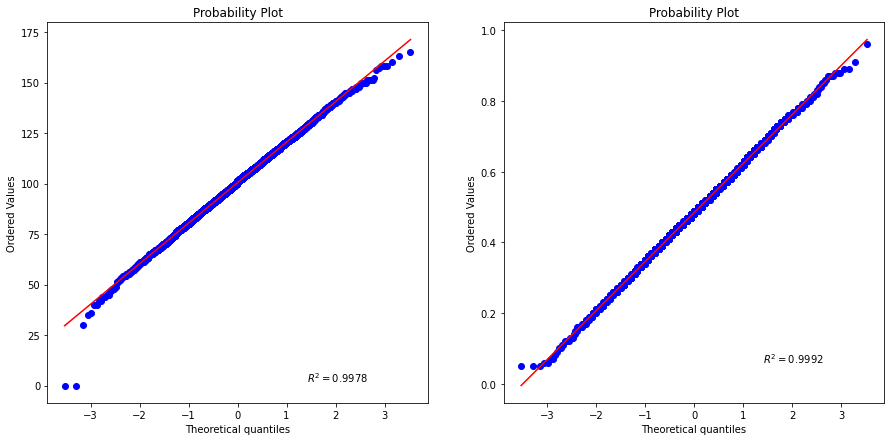

In [45]:
pylab.figure(figsize=(15,7))

pylab.subplot(1,2,1)
sc.stats.probplot(data.day_calls, dist="norm", plot=pylab, rvalue=True)
pylab.subplot(1,2,2)
sc.stats.probplot(data.mes_estim, dist="norm", plot=pylab, rvalue=True)

pylab.show()

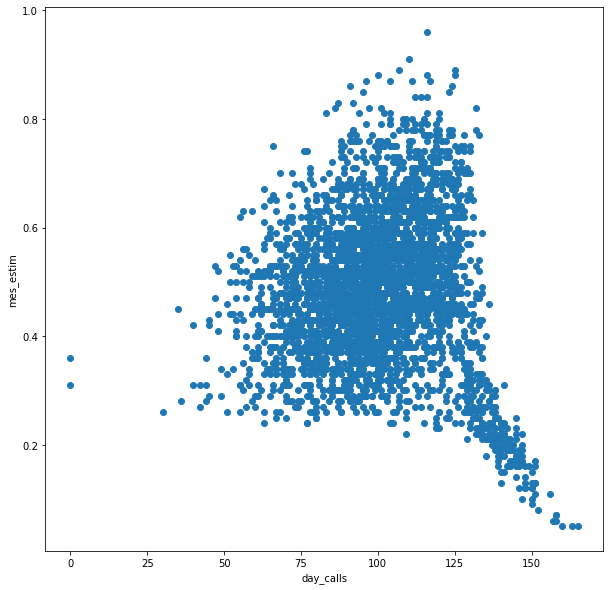

In [48]:
pylab.figure(figsize=(10,10))

pylab.scatter(data.day_calls, data.mes_estim)
pylab.xlabel('day_calls')
pylab.ylabel('mes_estim')

pylab.show()

Ответ: (1 балов)

- Посчитанные корреляции и их значимости говорят лишь о том, что необходимо взглянуть на данные глазами и попытаться понять, что приводит к таким (противоречивым?) результатам.

# Task 8

Посчитайте значение коэффицента корреляции Крамера между двумя признаками:  штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1).  Что можно сказать о достигаемом уровне значимости при проверке гипотезы о равенство нулю этого коэффициента?

- Достигаемый уровень значимости < 0.05, то есть, отличие от нуля значения коэффицента Крамера значимо.  

- Достигаемый уровень значимости > 0.05, то есть, отличие от нуля значения коэффицента Крамера незначимо.  

- Для вычисления коэффициента Крамера используется значение статистики xи-квадрат, на которую мы не можем положиться применительно к нашим данным. 

- Коэффициент корреляции Крамера не может быть использован для сравнения связи этих двух признаков, потому что  он используется для таблиц сопряженности, где каждая из размерностей больше двух. Если хотя бы одна из размерностей равна 2, то нужно использовать коэффициент корреляции Мэтьюса. 

In [50]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [102]:
print('V Cramer stat value: %.4f' % cramers_stat(data_states.to_numpy()))

V Cramer stat value: 0.2004


In [107]:
print('p-value: %.4f' % stats.chi2_contingency(data_states.values)[1])

p-value: 0.7098


Ответ: (0 балов)

- Достигаемый уровень значимости > 0.05, то есть, отличие от нуля значения коэффицента Крамера незначимо. 

Ответ: (1 балов)

- Для вычисления коэффициента Крамера используется значение статистики xи-квадрат, на которую мы не можем положиться применительно к нашим данным. 

# Task 9

Вы прослушали большой курс и к текущему моменту обладете достаточными знаниями, чтобы попытаться самостоятельно выбрать нужный метод / инструмент / статистический критерий и сделать правильное заключение. 

В этой части задания вам нужно будет самостоятельно решить, с помощью каких методов можно провести анализ эффективности удержания (churn) с помощью раличных методов (treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1). 

Что можно сказать об этих двух методах (treatment = 0, treatment = 2)? Одинаковы ли они с точки зрения эффективности? Каким бы методом вы бы посоветовали воспользоваться компании?

Не забудьте про поправку на множественную проверку!  И не пользуйтесь односторонними альтернативами, поскольку вы не знаете, к каким действительно последствиям приводят тестируемые методы  (treatment = 0, treatment = 2) !

- Ни один из методов не показал значительного улучшения относительно других, о чем говорит групповой статистический критерий. 

- treatment = 0 статистически значимо отличается от контрольной  группы treatment = 1

- treatment = 2 статистически значимо отличается от контрольной  группы treatment = 1

- В дальнейшем телеком компании рекомендуется использовать  и treatment = 0, и treatment = 2 для наибольшей эффективности удержения абонентов. 

- Отличие  между  treatment = 0 и treatment = 2 относительно влияния на уровень churn статистически незначимо. 

In [175]:
pivot_table = pd.pivot_table(data, columns=['treatment','churn'], index='state', values='account_length', fill_value=0, aggfunc=len)
pivot_table.head()

treatment      0            1            2      
churn     False. True. False. True. False. True.
state                                           
AK            15     2     19     1     15     0
AL            22     1     25     5     25     2
AR            14     3     11     5     19     3
AZ            26     0     17     2     17     2
CA            10     3     10     5      5     1

In [65]:
#proportions of churn = 1 for each treatment
props_churn = np.array([pivot_table.loc[:, treat].loc[:, "True."].sum() / 
                        (pivot_table.loc[:, treat].loc[:, "False."].sum() + 
                         pivot_table.loc[:, treat].loc[:, "True."].sum())
                        for treat in range(3)])

for i, prop in enumerate(props_churn): print('Treatment #%d prop. of churn = 1: %.4f' % (i, prop))

Treatment #0 prop. of churn = 1: 0.1456
Treatment #1 prop. of churn = 1: 0.1641
Treatment #2 prop. of churn = 1: 0.1251


In [203]:
pivot_table_all_churn = pd.pivot_table(data, columns=['treatment'], index='state', values='churn', fill_value=0, aggfunc=len)
pivot_table_all_churn.head()

treatment,0,1,2
state,,,
AK,17,20,15
AL,23,30,27
AR,17,16,22
AZ,26,19,19
CA,13,15,6


In [199]:
pivot_table_new = pd.pivot_table(data[data['churn'] == "True."], columns=['treatment'], index='state', values='churn', fill_value=0, aggfunc=len)
pivot_table_new.head()

treatment,0,1,2
state,,,
AK,2,1,0
AL,1,5,2
AR,3,5,3
AZ,0,2,2
CA,3,5,1


In [206]:
%%time
#Mann - Whitney test
mann_whitney_data = []

for i, treat_1 in enumerate(pivot_table_new.columns):
    for j, treat_2 in enumerate(pivot_table_new.columns):
        if i >= j:
            continue
        
        statistic, pvalue = sc.stats.mannwhitneyu(pivot_table_new.loc[:,treat_1], pivot_table_new.loc[:,treat_2])
        mann_whitney_data.append([treat_1, treat_2, statistic, pvalue])

CPU times: user 7.61 ms, sys: 351 µs, total: 7.96 ms
Wall time: 5.56 ms


In [207]:
mann_whitney_table = pd.DataFrame.from_records(mann_whitney_data)
mann_whitney_table.columns = ['Treat_A', 'Treat_B', 'M-W stat', 'p_value']
mann_whitney_table.head()

,Treat_A,Treat_B,M-W stat,p_value
0,0,1,1158.5,0.168650
1,0,2,1097.5,0.084288
2,1,2,966.5,0.011802


In [202]:
_, p_corrected, _, _ = multipletests(mann_whitney_table.iloc[:,3], alpha = 0.05, method = 'fdr_bh') 
p_corrected

array([0.16865016, 0.12643245, 0.03540507])

Ответ: (1 балов)

- treatment = 2 статистически значимо отличается от контрольной  группы treatment = 1
- Отличие между treatment = 0 и treatment = 2 относительно влияния на уровень churn статистически незначимо. 